In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.fftpack import fft

## with threshold

In [4]:
# Directory containing UCR time series files
dataset_directory = "C:/Users/User/Downloads/Datasets/Datasets"

threshold = 0.8

# Function to compute seasonality using autocorrelation
def detect_seasonality_autocorrelation(time_series, max_lag=500):
    autocorr = acf(time_series, nlags=max_lag, fft=True)
    significant_lags = np.where((autocorr > threshold) & (np.arange(len(autocorr)) > 2))[0] # Adjust threshold if needed
    return autocorr, significant_lags

# Function to compute seasonality using Fourier Transform
def detect_seasonality_fourier(time_series):
    freq_amplitude = np.abs(fft(time_series))
    dominant_frequencies = np.where(freq_amplitude > np.mean(freq_amplitude))[0]
    return dominant_frequencies

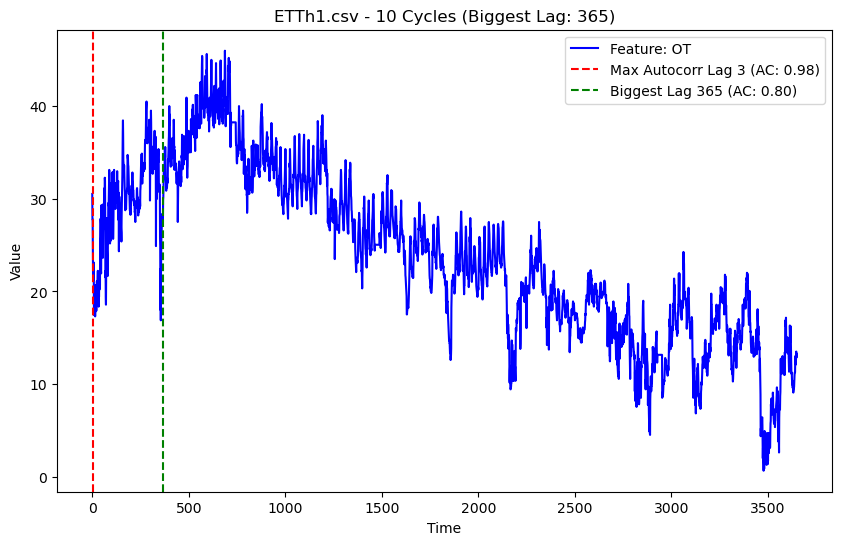

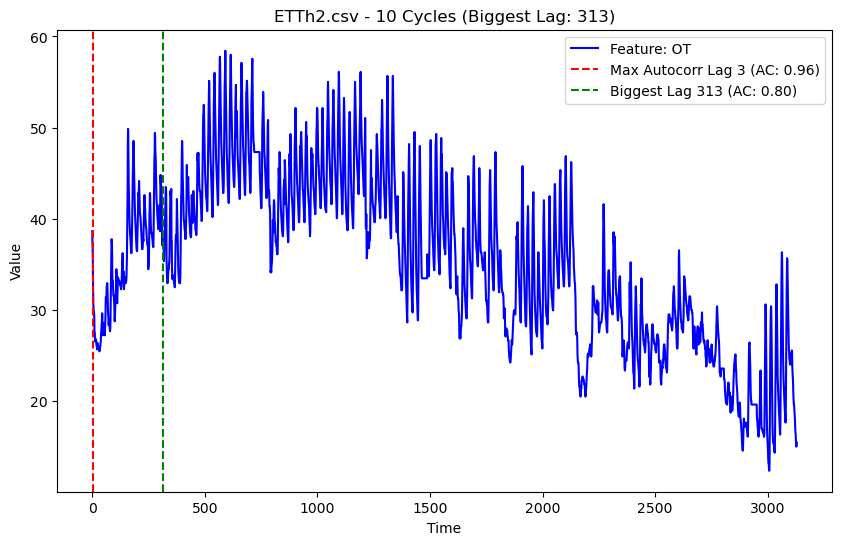

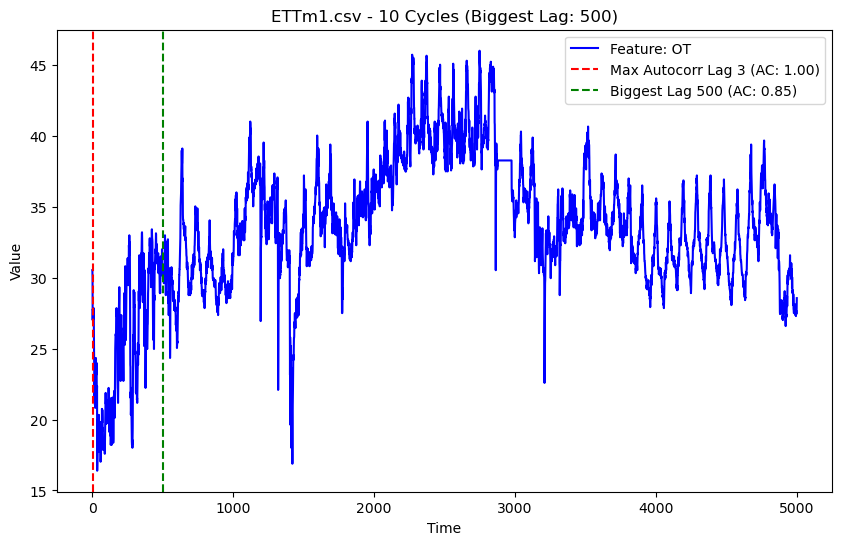

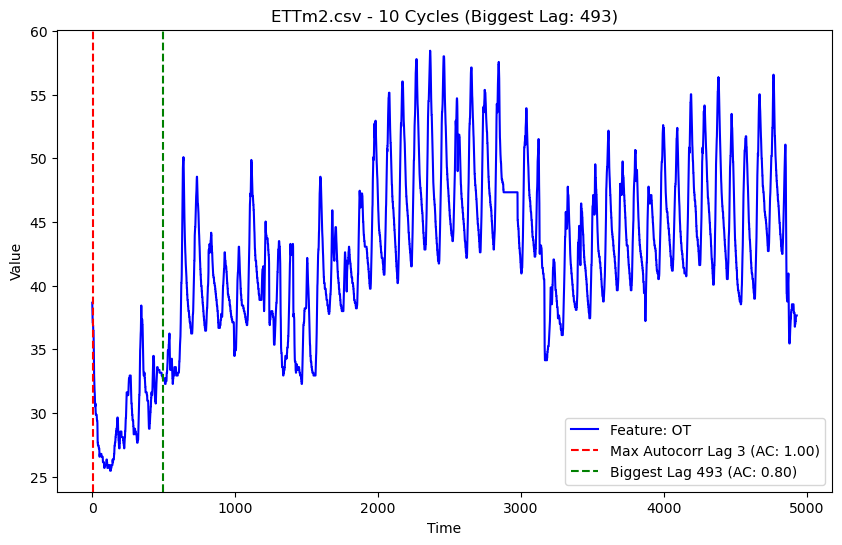

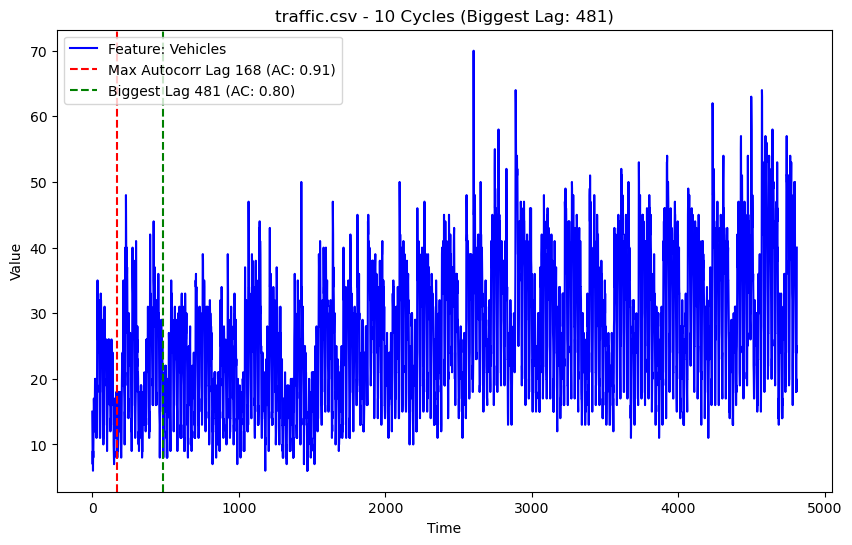

Seasonality analysis complete.
Total datasets analyzed: 5
Number of datasets with seasonality: 5
Percentage of datasets with seasonality: 100.00%


In [5]:
seasonality_results = []

for file_name in os.listdir(dataset_directory):
    if file_name.endswith(".csv"):  # Process only .csv files
        file_path = os.path.join(dataset_directory, file_name)
        
        # Load the dataset
        df = pd.read_csv(file_path)
        
        # Select the feature to analyze
        if file_name == "traffic.csv":
            feature = "Vehicles"
        elif file_name.startswith("ETT"):
            feature = "OT"
        else:
            print(f"Skipping file {file_name}: No specified feature for analysis.")
            continue
        
        if feature not in df.columns:
            print(f"Skipping file {file_name}: Feature '{feature}' not found in dataset.")
            continue
        
        # Extract the time series for the specified feature
        time_series = df[feature].values
        
        # Autocorrelation Analysis
        autocorr, significant_lags = detect_seasonality_autocorrelation(time_series)
        
        # Determine if the time series is seasonal
        has_seasonality = len(significant_lags) > 0
        
        if has_seasonality:
            # Find the lag with the highest autocorrelation
            max_lag_autocorr = significant_lags[np.argmax(autocorr[significant_lags])]
            max_lag_autocorr_value = autocorr[max_lag_autocorr]  # Value of max autocorrelation
            
            # Find the biggest significant lag
            biggest_lag = max(significant_lags)
            biggest_lag_value = autocorr[biggest_lag]  # Value of autocorrelation at the biggest lag
            
            # Extract K cycles based on the biggest lag
            K = 10  # Number of cycles to extract
            if len(time_series) >= K * biggest_lag:
                k_cycles = time_series[:K * biggest_lag]
            else:
                k_cycles = time_series  # If series is too short, plot all available data
            
            # Plot the K cycles
            plt.figure(figsize=(10, 6))
            plt.plot(k_cycles, label=f"Feature: {feature}", color="blue")
            
            # Add a vertical line for the lag with maximum autocorrelation
            plt.axvline(
                x=max_lag_autocorr,
                color="red",
                linestyle="--",
                label=f"Max Autocorr Lag {max_lag_autocorr} (AC: {max_lag_autocorr_value:.2f})"
            )
            
            # Add a vertical line for the biggest significant lag
            plt.axvline(
                x=biggest_lag,
                color="green",
                linestyle="--",
                label=f"Biggest Lag {biggest_lag} (AC: {biggest_lag_value:.2f})"
            )
            
            # Customize plot
            plt.title(f"{file_name} - {K} Cycles (Biggest Lag: {biggest_lag})")
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.show()

        
        # Record results
        seasonality_results.append({
            "file": file_name,
            "feature": feature,
            "has_seasonality": has_seasonality,
            "max_lag_autocorr": max_lag_autocorr if has_seasonality else None,
            "max_lag_autocorr_value": max_lag_autocorr_value if has_seasonality else None,
            "biggest_lag": biggest_lag if has_seasonality else None,
            "biggest_lag_value": biggest_lag_value if has_seasonality else None,
            "significant_lags": significant_lags.tolist() if has_seasonality else None
        })

# Save results to a CSV file
results_df = pd.DataFrame(seasonality_results)
results_df.to_csv("multivariate_seasonality_results.csv", index=False)

# Calculate and print the percentage of time series with seasonality
total_files = len(seasonality_results)
seasonal_files = sum(1 for result in seasonality_results if result["has_seasonality"])
percentage_seasonal = (seasonal_files / total_files) * 100

print(f"Seasonality analysis complete.")
print(f"Total datasets analyzed: {total_files}")
print(f"Number of datasets with seasonality: {seasonal_files}")
print(f"Percentage of datasets with seasonality: {percentage_seasonal:.2f}%")

# with confidence interval

In [6]:
# Directory containing UCR time series files
ucr_directory = "../datasets/processed"

confidence_level = 0.05

# Function to compute seasonality using autocorrelation with confidence intervals
def detect_seasonality_autocorrelation(time_series, max_lag=100, confidence_level=0.95):
    """
    Detects seasonality using autocorrelation with confidence intervals.

    Parameters:
        time_series (array-like): The input time series data.
        max_lag (int): Maximum number of lags to compute autocorrelation for.
        confidence_level (float): Confidence level for the interval.

    Returns:
        tuple: (autocorr, significant_lags) where
            autocorr is the autocorrelation array,
            significant_lags is a list of lags where the autocorrelation exceeds the confidence bounds.
    """
    # Compute autocorrelation and confidence intervals
    autocorr, conf_int = acf(time_series, nlags=max_lag, alpha=1-confidence_level, fft=True)
    
    # Upper confidence bound
    upper_bound = conf_int[:, 1]
    
    # Identify significant lags (where autocorrelation exceeds the upper confidence bound)
    significant_lags = np.where(autocorr > upper_bound)[0]
    
    return autocorr, significant_lags

# Function to compute seasonality using Fourier Transform
def detect_seasonality_fourier(time_series):
    freq_amplitude = np.abs(fft(time_series))
    dominant_frequencies = np.where(freq_amplitude > np.mean(freq_amplitude))[0]
    return dominant_frequencies


In [7]:
# Analyze each file in the UCR directory
seasonality_results = []

for file_name in os.listdir(ucr_directory):
    if file_name.endswith(".txt"):  # Process only .txt files
        file_path = os.path.join(ucr_directory, file_name)
        
        # Load the time series from the .txt file
        time_series = np.loadtxt(file_path)
        
        # Autocorrelation Analysis
        autocorr, significant_lags = detect_seasonality_autocorrelation(time_series,confidence_level=confidence_level)
        
        # Determine if the time series is seasonal
        has_seasonality = len(significant_lags) > 0
        
        if has_seasonality:
            # Find the lag with the highest autocorrelation
            max_lag_autocorr = significant_lags[np.argmax(autocorr[significant_lags])]
            max_lag_autocorr_value = autocorr[max_lag_autocorr]  # Value of max autocorrelation
            
            # Find the biggest significant lag
            biggest_lag = max(significant_lags)
            biggest_lag_value = autocorr[biggest_lag]  # Value of autocorrelation at the biggest lag
            
            # Extract K cycles based on the biggest lag
            K = 4  # Number of cycles to extract
            if len(time_series) >= K * biggest_lag:
                k_cycles = time_series[:K * biggest_lag]
            else:
                k_cycles = time_series  # If series is too short, plot all available data
            
            # Plot the K cycles
            plt.figure(figsize=(10, 6))
            plt.plot(k_cycles, label="Time Series", color="blue")
            
            # Add a vertical line for the lag with maximum autocorrelation
            plt.axvline(
                x=max_lag_autocorr,
                color="red",
                linestyle="--",
                label=f"Max Autocorr Lag {max_lag_autocorr} (AC: {max_lag_autocorr_value:.2f})"
            )
            
            # Add a vertical line for the biggest significant lag
            plt.axvline(
                x=biggest_lag,
                color="green",
                linestyle="--",
                label=f"Biggest Lag {biggest_lag} (AC: {biggest_lag_value:.2f})"
            )
            
            # Customize plot
            plt.title(f"{file_name} - K Cycles (Biggest Lag: {biggest_lag})")
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.show()
        
        # Record results
        seasonality_results.append({
            "file": file_name,
            "has_seasonality": has_seasonality,
            "max_lag_autocorr": max_lag_autocorr if has_seasonality else None,
            "max_lag_autocorr_value": max_lag_autocorr_value if has_seasonality else None,
            "biggest_lag": biggest_lag if has_seasonality else None,
            "biggest_lag_value": biggest_lag_value if has_seasonality else None,
        })

# Save results to a CSV file
results_df = pd.DataFrame(seasonality_results)
results_df.to_csv(f"ucr_seasonality_results_with_ci_{confidence_level}.csv", index=False)

print(f"Seasonality analysis complete. Results saved to 'ucr_seasonality_results_with_ci_{confidence_level}.csv'.")

Seasonality analysis complete. Results saved to 'ucr_seasonality_results_with_ci_0.05.csv'.
